# Using Geoprocessing tools

This sample notebooks shows how geoprocessing tools can be used in an analysis. The analysis below uses a geoprocessing tool to  deduce the path that the debris of a crashed airplane would take if it went down at different places in the ocean. It should be noted that this tool is for the purpose of demonstrating GIS functionality and the results should not be treated as authoritative. Further this tool excludes wind or atmospheric conditions, which are critical for a real-world analysis.

In [1]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from IPython.display import display


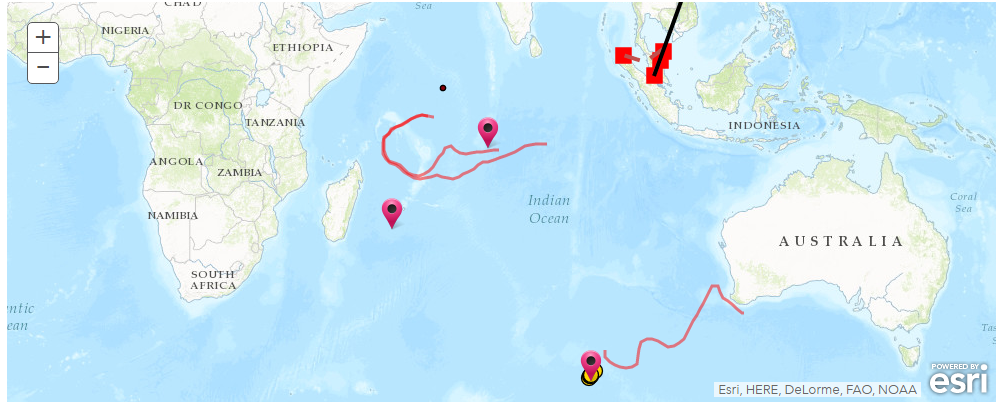

In [2]:
gis = GIS()
map1 = gis.map()
map1

There have been speculations that the unfortunate disappearance of flight [MH370](https://en.wikipedia.org/wiki/Malaysia_Airlines_Flight_370) is tied to [Diego Garcia](https://en.wikipedia.org/wiki/Diego_Garcia) an atoll in the central Indian Ocean, in addition to other search locations in southern Indian Ocean to west of Australia. The code below plots these locations on the map:

In [3]:
# set the map's extent by geocoding the location
diegogarcia = geocode("Diego Garcia")[0]
map1.extent = diegogarcia['extent']

In [4]:
# geocode location of La Reunion island
lareunion = geocode("La Reunion")[0]

In [5]:
# Annotate the map by plotting Diego Garcia, and two other search locations
map1.draw(lareunion['location'], {"title": "Reunion Island", "content": "Debris found"})
map1.draw(diegogarcia['location'], {"title": "Diego Garcia", "content": "Naval Support Facility Diego Garcia"})
map1.draw([-43.5, 90.5], {"title":"Search Location", "content":"Predicted crash location"})

# Render a feature layer representing the search area
# Source: http://www.amsa.gov.au/media/incidents/images/DIGO_00718_01_14.jpg
map1.add_layer({"type":"FeatureLayer", 
                "url" : "http://services.arcgis.com/WQ9KVmV6xGGMnCiQ/arcgis/rest/services/MH370Search/FeatureServer/1"})

We can search ArcGIS Online for content related to the missing airliner, and bring in layers that we want to use for our analysis and visualization:

In [6]:
mh370items = gis.content.search("MH370", "feature service", max_items=6)
for item in mh370items:
    display(item)

<Item title:"MH370_Flight_Path" type:Feature Service owner:bflanagan_bureau>

<Item title:"Arc" type:Feature Service owner:bflanagan_bureau>

<Item title:"MH370Search" type:Feature Service owner:bflanagan_bureau>

<Item title:"ActualFlightRoute" type:Feature Service owner:bflanagan_bureau>

<Item title:"SatelliteLocation" type:Feature Service owner:bflanagan_bureau>

<Item title:"mh370debris" type:Feature Service owner:bflanagan_bureau>

Let's add a few of these layers to the map for analysis

In [7]:
map1.add_layer(mh370items[0])
map1.add_layer(mh370items[4])
map1.add_layer(mh370items[5])

In [8]:
map1.zoom = 6

# Using geoprocessing tools

To find the paths that the plane debris could take, we need geoprocessing tools that can use ocean currents for their analysis.

Tools are organized into toolboxes. In the Web GIS, toolboxes are stored as Items of type='geoprocessing toolbox'.

In the code below, we search ArcGIS Online for the "Ocean Currents" geoprocessing toolbox that contains tools to calculate the path of an unpowered vessel drifiting in ocean currents from a user defined starting point.

<div class="alert alert-warning">

<b>Note:</b> The tools are for demonstration of GIS functionality only and excludes wind or atmospheric conditions, which are critical for a real-world analysis

</div>

In [9]:
toolbox_item = gis.content.search("Ocean Currents", item_type="geoprocessing toolbox", max_items=1)[0]
toolbox_item

<Item title:"Ocean Currents" type:Geoprocessing Service owner:esri_apac>

We create a **`Toolbox`** object out of this item using `arcgis.geoprocessing.Toolbox`

In [10]:
from arcgis.geoprocessing import import_toolbox

ocean_currents = import_toolbox(toolbox_item)

The ArcGIS API for Python dynamically adds a method (in this case the **`message_in_a_bottle()`** method) for each geoprocessing tool provided by the toolbox. 

Such methods are added along with documentation of the geoprocessing tool and can be queried through intellisence as well as programmatically. The method help contains the method signature, including the names and types of the input parameters. If the parameters have default values, they are shown, and need not be passed in when invoking the method.

Geoprocessing tools use Python types (bool, float, int, str, datetime.date) as well as custom types such as FeatureSet, LinearUnit, DataFile and RasterData defined in the API, as input/output parameters.

In [11]:
help(ocean_currents.message_in_a_bottle)

Help on function message_in_a_bottle:

message_in_a_bottle(input_point:arcgis.features.feature.FeatureSet={'Fields': [{'name': 'FID', 'type': 'esriFieldTypeOID', 'alias': 'FID'}, {'name': 'Shape', 'type': 'esriFieldTypeGeometry', 'alias': 'Shape'}, {'name': 'Id', 'type': 'esriFieldTypeInteger', 'alias': 'Id'}], 'spatialReference': {'wkid': 4326}, 'geometryType': 'esriGeometryPoint', 'fields': [{'name': 'FID', 'type': 'esriFieldTypeOID', 'alias': 'FID'}, {'name': 'Shape', 'type': 'esriFieldTypeGeometry', 'alias': 'Shape'}, {'name': 'Id', 'type': 'esriFieldTypeInteger', 'alias': 'Id'}]}, days:float=150, gis=None) -> arcgis.features.feature.FeatureSet
            
    
    
    Parameters:
    
       input_point: Input Point (FeatureSet). Required parameter. 
    
       days: Days (float). Required parameter. 
    
            gis: Optional, the GIS on which this tool runs. If not specified, the active GIS is used.
    
    
    Returns: 
       output - Output as a FeatureSet
    
    

From the output of the previous cell, we can see, the geoprocessing task requires 2 input parameters: a `FeatureSet` which contains the input location as a point feature and a `float` parameter containing the number of days to be used for prediction. 
When we click the map, we want to invoke this geoprocessing task and pass in the clicked location. We can do this by adding an event listener to the map using `map.on_click()`. The event listener then calls the tool with the clicked location.

The analysis results from this tool would contain the paths that the debris would take if the plane went down at the clicked point. Next, we draw the path on the map using `map.draw()` as shown in the code below.

In [12]:
from arcgis.features import FeatureSet, Feature

def do_analysis(m, g):
    print("Computing the path that debris would take...")
    
    # Parameter `g` contains the co-ordinates of the clicked location
    
    # Construct a FeatureSet object from the clicked locaiton
    my_feature_set = FeatureSet([Feature(g)])
    
    # Pass the input location as a FeatureSet
    ret = ocean_currents.message_in_a_bottle(my_feature_set, 150)
    
    # Render the resulting FeatureSet on the map using `draw()` method
    map1.draw(ret)
    
# Set the callback function that performs analysis. The `do_analysis` function is called whenever user clicks on the map.
map1.on_click(do_analysis)

Click around on the map, near Diego Garcia as well as at the search locations to find the paths the debris could have taken and find if it could have reached La Reunion.

<div class="alert alert-warning">

<b>Note:</b> The tool expects an input location that is within the worlds oceans and will not work if clicked within land masses. To know more about this tool, visit the <a href="http://sampleserver1b.arcgisonline.com/arcgisoutput/Specialty_ESRI_Currents_World/MessageInABottle.htm">help documentation</a>.

</div>